# Cosmólogos por un Día. Determinando el valor de $H_0$ usando Supernovas tipo Ia

<div style="max-width:300px; float: left; margin-right: 1em">

![](figures/logos/logo.jpg)

</div>
<span style="color: red;">Departamento de Astronomía, Universidad de Chile</span> <br>
Facultad de Ciencias Físicas y Matemáticas <br>
Universidad de Chile <br>
AS2001 - Astronomía General <br>
Otoño 2025 <br>
Profesora: Laura Perez <br>
<strong>Profesor Auxilar/Author: Steve Jurado</strong> <br>


In [1]:
import numpy as np
import pandas as pd
import sqlalchemy as sa
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import astropy.units as u
import astropy.constants as const


from alerce.core import Alerce
alerce_client = Alerce()

import warnings
warnings.filterwarnings('ignore')

Se activa la conexión a internet usando las credenciales publicas proporcionadas por ALeRCE para usar su API.

In [6]:
import requests

credentials_file = 'https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json'
params = requests.get(credentials_file).json()['params']
engine = sa.create_engine("postgresql+psycopg2://" + params["user"] \
                          + ":" + params["password"] + "@" + params["host"] \
                          + "/" + params["dbname"])
conn = engine.connect()

Se genera el `query` para obtener los datos de las supernovas tipo Ia classificadas por ALeRCE usando usando el LC classifier. Seleccionando aquellas que tienen un valor de `probability` mayor a 0.5 y ordenandolas en orden decreciente de probabilidad.

In [7]:
query = """
SELECT
    *
FROM
    probability
WHERE
    classifier_name = 'lc_classifier'
    AND class_name = 'SNIa'
    AND probability >= 0.5
ORDER BY
    probability DESC
LIMIT 20
"""
alerce_dataframe = pd.read_sql_query(query, conn)
alerce_dataframe.head()


,oid,classifier_name,classifier_version,class_name,probability,ranking
0,ZTF22aalpfln,lc_classifier,hierarchical_rf_1.1.0,SNIa,0.722000,1
1,ZTF20acobvxk,lc_classifier,hierarchical_rf_1.1.0,SNIa,0.722000,1
2,ZTF21abuyhau,lc_classifier,hierarchical_rf_1.1.0,SNIa,0.720000,1
3,ZTF21abywdxt,lc_classifier,hierarchical_rf_1.1.0,SNIa,0.716564,1
4,ZTF22abqdmwt,lc_classifier,hierarchical_rf_1.1.0,SNIa,0.714568,1


In [8]:
lightcurves = alerce_client.query_detections(oid=alerce_dataframe['oid'][0], format='pandas')
lightcurves.head()

,tid,mjd,candid,fid,pid,diffmaglim,isdiffpos,nid,distnr,magpsf,...,corrected,dubious,step_id_corr,phase,parent_candid,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext,drb,rfid
0,ztf,59724.349155,1970349155415015020,1,1970349155415,20.667000,1,1970,2.248830,20.290900,...,False,False,correction_1.0.6,0.0,1.972325e+18,NaN,NaN,NaN,NaN,NaN
1,ztf,59726.325266,1972325265415015017,1,1972325265415,20.751100,1,1972,2.487580,19.570100,...,False,False,1.1.2,0.0,1.975383e+18,NaN,NaN,NaN,NaN,NaN
2,ztf,59726.389051,1972389055415015018,2,1972389055415,20.541000,1,1972,0.991249,19.533000,...,True,False,1.1.2,0.0,1.975383e+18,18.514112,0.034334,0.061593,NaN,NaN
3,ztf,59729.382604,1975382605415015013,1,1975382605415,20.166122,1,1975,2.587503,18.963701,...,False,False,1.1.2,0.0,NaN,NaN,NaN,NaN,0.999995,759120154.0
4,ztf,59731.308970,1977308965415015012,2,1977308965415,20.559162,1,1977,0.924376,18.876217,...,True,False,1.1.2,0.0,NaN,18.208439,0.041287,0.056513,0.999782,759120254.0


Obtenemos las curvas de luz de los primeros 10 objetos en `alerce_client`. Las agrupamos en un solo `DataFrame` para su análisis posterior.

Además seleccionamos solo las columnas que nos interesan para el análisis: `oid`, `mjd`, `magpsf`, `sigmapsf` y `fid`, donde:
- `oid`: Identificador único del objeto.
- `mjd`: Tiempo de la observación en días julianos modificados.
- `magpsf`: Magnitud aparente del objeto.
- `sigmapsf`: Incertidumbre en la magnitud aparente.
- `fid`: Filtro utilizado en la observación (1 para g, 2 para r, 3 para i).

In [9]:
lightcurves = []
num_lghtcurves = 10
for oid in alerce_dataframe['oid'].head(num_lghtcurves):
    lightcurve = alerce_client.query_detections(oid=oid, format='pandas')
    lightcurve['oid'] = oid
    lightcurves.append(lightcurve)
lightcurves = pd.concat(lightcurves, ignore_index=True)

# Filtramos solo los datos necesarios
lightcurves = lightcurves[['oid', 'mjd', 'magpsf', 'sigmapsf', 'fid']]

# Excluimos el filtro i (fid=3)
lightcurves = lightcurves[lightcurves['fid'] != 3] 

# Esto cierra la conexión a la base de datos
conn.close()

In [10]:
print(lightcurves.head())
print(lightcurves.columns, lightcurves.shape)
print(lightcurves.dtypes)
print(lightcurves.describe())

            oid           mjd     magpsf  sigmapsf  fid
0  ZTF22aalpfln  59724.349155  20.290900  0.231469    1
1  ZTF22aalpfln  59726.325266  19.570100  0.145437    1
2  ZTF22aalpfln  59726.389051  19.533000  0.157430    2
3  ZTF22aalpfln  59729.382604  18.963701  0.109318    1
4  ZTF22aalpfln  59731.308970  18.876217  0.104534    2
Index(['oid', 'mjd', 'magpsf', 'sigmapsf', 'fid'], dtype='object') (270, 5)
oid          object
mjd         float64
magpsf      float64
sigmapsf    float64
fid           int64
dtype: object
                mjd      magpsf    sigmapsf         fid
count    270.000000  270.000000  270.000000  270.000000
mean   59584.358777   18.897519    0.120860    1.514815
std      315.999840    0.584636    0.060249    0.500709
min    59149.448125   17.689812    0.040877    1.000000
25%    59452.545692   18.465402    0.077202    1.000000
50%    59487.750804   18.812645    0.104724    2.000000
75%    59878.345799   19.229323    0.153220    2.000000
max    60237.153507   20.7

Ahora vamos a graficar 9 de las 10 curvas de luz de las supernovas tipo Ia obtenidas. Cada gráfica mostrará la magnitud aparente en función del tiempo (mjd) para cada objeto, diferenciando los puntos según el filtro utilizado ($g$, $r$).

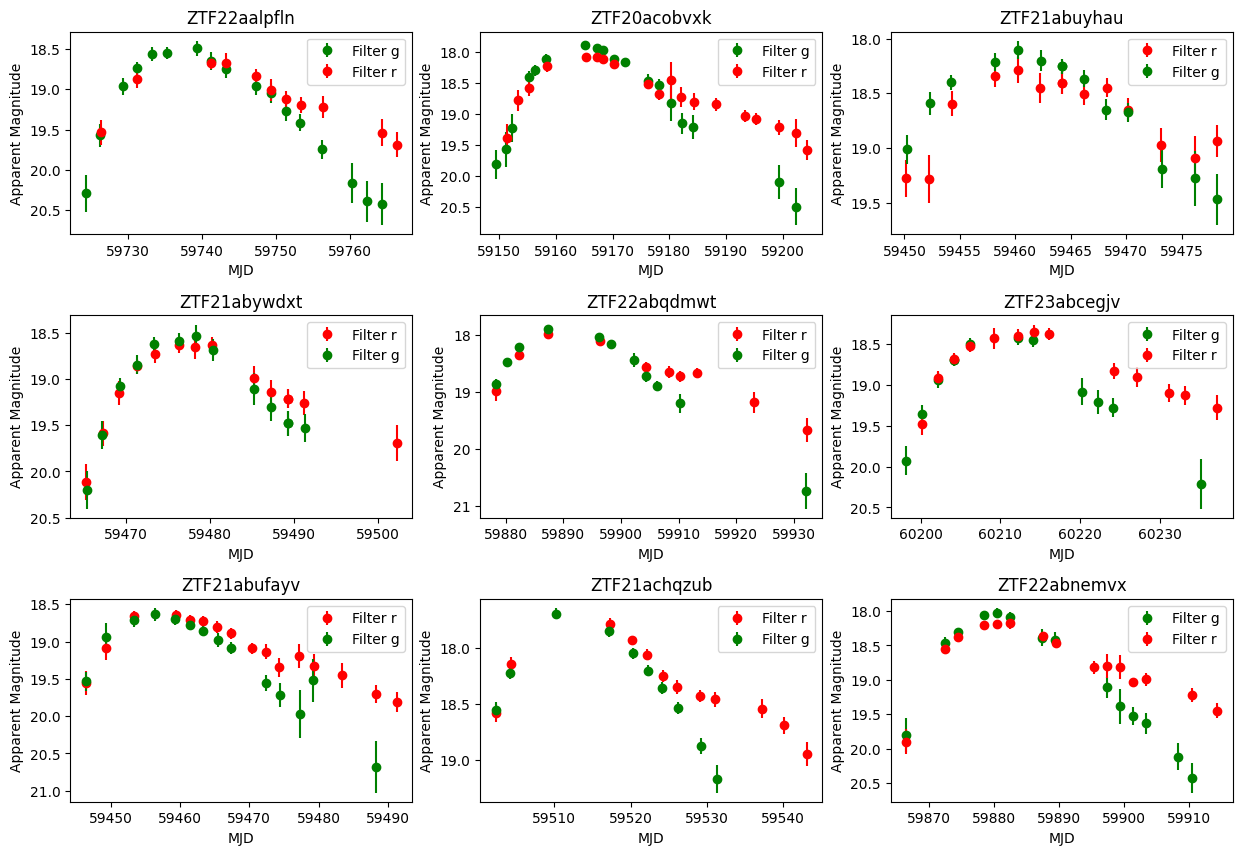

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10), gridspec_kw={'hspace': 0.4, 'wspace': 0.2})
for i, oid in enumerate(lightcurves['oid'].unique()[:9]):
    lc = lightcurves[lightcurves['oid'] == oid]
    
    for fid in lc['fid'].unique():
        filter_name  = 'g' if fid == 1 else 'r'
        ax[i//3, i%3].errorbar(lc[lc['fid'] == fid]['mjd'], 
                               lc[lc['fid'] == fid]['magpsf'], 
                               lc[lc['fid'] == fid]['sigmapsf'], fmt='o',
                               label=f'Filter {filter_name}', color='g' if fid == 1 else 'r'
                            )
    ax[i//3, i%3].invert_yaxis()
    ax[i//3, i%3].set_title(f'{oid}')
    ax[i//3, i%3].set_xlabel('MJD')
    ax[i//3, i%3].set_ylabel('Apparent Magnitude')
    ax[i//3, i%3].legend()
    
plt.savefig('results/lightcurves_sample.png', dpi=300, bbox_inches='tight')

Para ajustar cada curva de luz, utilizaremos un polinomio de grado 10. Este ajuste nos permitirá modelar la evolución de la magnitud aparente a lo largo del tiempo para cada supernova. Utilizaremos la función `numpy.polyfit` para realizar el ajuste polinomial y `numpy.polyval` para evaluar el polinomio ajustado en los puntos de tiempo correspondientes.

Además, calcularemos la derivada del polinomio ajustado utilizando `numpy.polyder`. Esto nos permitirá identificar los puntos críticos en la curva de luz, que corresponden a los máximos y mínimos locales. Encontraremos las raíces de la derivada utilizando `numpy.roots`, lo que nos dará los tiempos en los que ocurren estos puntos críticos. Finalmente, graficaremos las curvas de luz junto con los puntos críticos identificados para cada supernova

In [12]:
ndeg = 10
metadatos = {}

for oid, fid in lightcurves.groupby(['oid', 'fid']).groups.keys():
    lc = lightcurves[(lightcurves['oid'] == oid) & (lightcurves['fid'] == fid)]
    
    # Ajuste polinomial de grado n-th.
    coeffs     = np.polyfit(lc['mjd'], lc['magpsf'], deg=ndeg)
    poly       = np.poly1d(coeffs)
    poly_deriv = np.polyder(poly) # Calcular la derivada del polinomio
    
    # Encontrar las raíces de la derivada
    mag_roots      = np.roots(poly_deriv)
    mjdmin, mjdmax = lc['mjd'].min(), lc['mjd'].max()
    peaks_mjd      = mag_roots[
        np.isreal(mag_roots) &
        (mag_roots.real >= mjdmin) &
        (mag_roots.real <= mjdmax)
    ].real
    
    # Evaluar el polinomio en los puntos críticos para encontrar los máximos y mínimos
    magmax = poly(peaks_mjd)
    
    # Encontrar el máximo (mínimo en magnitud)
    idxmax = np.argmin(magmax)
    
    # Obtener los valores correspondientes
    mjdmax = peaks_mjd[idxmax]
    magmax = magmax[idxmax]
    
    if oid not in metadatos: metadatos[oid] = {}
        
    metadatos[oid][fid] = {
        'mjdmax': mjdmax,
        'magmax': magmax
    }

lightcurves.attrs = metadatos

Ahora que tenemos las magnitudes máximas y los tiempos correspondientes a estos máximos en cada filtro para cada supernova almancenada en los atributos del DataFrame `lightcurves`, veremos estos resultados graficamente.

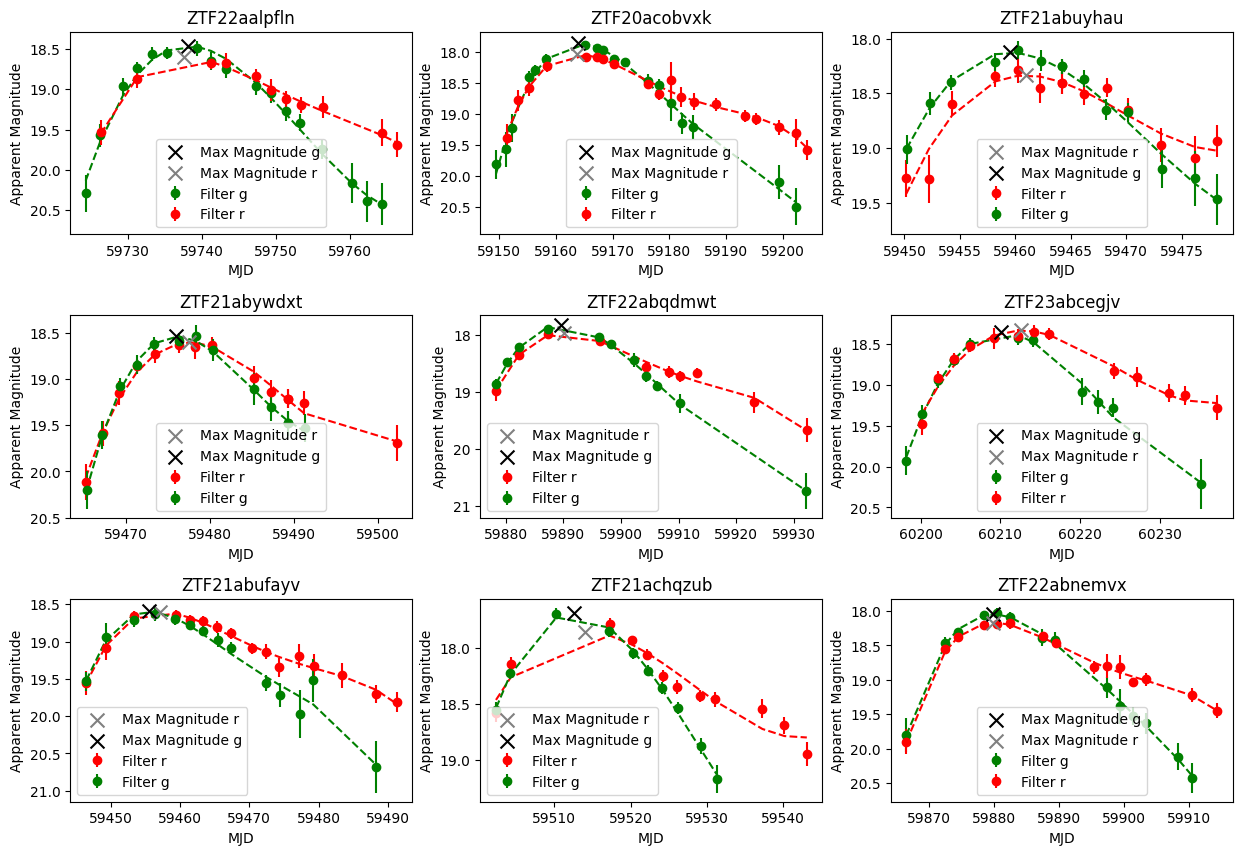

In [13]:
metalcs = lightcurves.attrs
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10), gridspec_kw={'hspace': 0.4, 'wspace': 0.2})  
for i, oid in enumerate(lightcurves['oid'].unique()[:9]):
    lc = lightcurves[lightcurves['oid'] == oid]
    
    for fid in lc['fid'].unique():
        filter_name  = 'g' if fid == 1 else 'r'
        mjdmax = metalcs[oid][fid]['mjdmax'] 
        magmax = metalcs[oid][fid]['magmax']
        ax[i//3, i%3].errorbar(lc[lc['fid'] == fid]['mjd'], 
                               lc[lc['fid'] == fid]['magpsf'], 
                               lc[lc['fid'] == fid]['sigmapsf'], fmt='o',
                               label=f'Filter {filter_name}', color='g' if fid == 1 else 'r'
                            )
        ax[i//3, i%3].scatter(mjdmax, magmax, marker='x', s=100, zorder=5, color='k' if fid == 1 else 'gray', label=f'Max Magnitude {filter_name}')
        ax[i//3, i%3].plot(lc[lc['fid'] == fid]['mjd'], 
                           np.poly1d(np.polyfit(lc[lc['fid'] == fid]['mjd'], lc[lc['fid'] == fid]['magpsf'], deg=ndeg))(lc[lc['fid'] == fid]['mjd']),
                           linestyle='--', color='g' if fid == 1 else 'r'
                          )
    ax[i//3, i%3].invert_yaxis()
    ax[i//3, i%3].set_title(f'{oid}')
    ax[i//3, i%3].set_xlabel('MJD')
    ax[i//3, i%3].set_ylabel('Apparent Magnitude')
    ax[i//3, i%3].legend()

Se tiene que la magnitud absoluta en el máximo de la curva de luz de las supernovas tipo Ia es aproximadamente en el filtro $B$ de tal manera que $\langle M_B \rangle \approx M_B = -19.3 \pm 0.3$. Usaremos las siguiente relaciones para obtener este máximo en los filtros $g$ y $r$:

$$ M_g =  M_B - 0.15 = -19.45 \pm 0.3 $$
$$ M_r =  M_B - 0.25 = -19.55 \pm 0.3 $$

Con esto podemos calcular la distancia a cada supernova en cada filtro usando la relación de distancia módulo:

$$ m_\text{max} - M_\text{max} = 5 \log(d_L) - 5 $$

donde $m$ es la magnitud aparente en el máximo de la curva de luz (asumiendo un error de $\sigma_m = 0.001$), $M$ es la magnitud absoluta en el máximo y $d_L$ es la distancia en parsecs. Despejando para $d_L$ tenemos:

$$ d_L = 10^{(m_\text{max} - M_\text{max} + 5)/5} $$

el error en la distancia se puede calcular usando propagación de errores:

$$ \sigma_{d_L} = \frac{\ln(10)}{5} d_L \sqrt{\sigma_{m_\text{max}}^2 + \sigma_{M_\text{max}}^2} $$

donde $\sigma_M$ es el error en la magnitud absoluta. Agregamos este resutado al DataFrame `lightcurves` creado anteriormente.

In [14]:
for oid in metalcs:
    for fid in metalcs[oid]:
        mjdmax = metalcs[oid][fid]['mjdmax']
        magmax = metalcs[oid][fid]['magmax']
        
        # Cálculo de la distancia
        # conversión de magnitud absoluta entre filtros g y r        
        conv_mag = -0.15 if fid == 1 else -0.25
        
        dist      = 10**((magmax - (-19.3 + conv_mag) + 5) / 5)  # in parsecs
        sigmadist = (np.log(10) / 5) * dist * np.sqrt(0.001**2 + 0.3**2)  # in parsecs   
        
        # Guardar los resultados en el diccionario
        # de los metadatos
        metalcs[oid][fid]['dist']      = dist
        metalcs[oid][fid]['sigmadist'] = sigmadist
        
lightcurves.attrs = metalcs

Usando el explorar de ALeRCE obtenemos los valores de redshift que son reportados por Transient Name Server para cada supernova en un diccionario llamado `tns_redshift` y guardaremos estos valores en los metadatos de la curvas de luz.

In [15]:
oids = ['ZTF20acobvxk', 'ZTF20acoqlav', 'ZTF21abufayv','ZTF21abuyhau',
    'ZTF21abywdxt', 'ZTF21achqzub', 'ZTF22aalpfln','ZTF22abnemvx',
    'ZTF22abqdmwt','ZTF23abcegjv',
]
redshifts = [0.08, 0.09, 0.085, 0.066, 0.07, 0.04, 0.086, 0.063, 0.065, 0.06]
tns_redshift = {
    'oids': oids,
    'redshifts': redshifts
}

for oid, z in zip(tns_redshift['oids'], tns_redshift['redshifts']):
    if oid in metalcs:
        for fid in metalcs[oid]:
            metalcs[oid][fid]['redshift'] = z
            
lightcurves.attrs = metalcs

Ahora procederemos a graficar la relación entre la distancia obtenida y el redshift para cada supernova tipo Ia en los filtros $g$ y $r$. Esta gráfica nos permitirá visualizar cómo varía la distancia con el redshift, lo cual es fundamental para entender la expansión del universo.

La relacion entre la distancia y el redshift puede ser modelada usando la ley de Hubble, que establece que la velocidad de recesión de una galaxia es proporcional a su distancia. La constante de proporcionalidad es conocida como la constante de Hubble, $H_0$. La idea es ajustar los datos obtenidos a un modelo de la forma:

$$ z = \frac{H_0}{c} d_L $$
$$ \sigma_z = \frac{H_0}{c} \sigma_{d_L} $$

donde $c$ es la velocidad de la luz y $z$ es el redshift. Usaremos `scipy.optimize.curve_fit` para realizar este ajuste y obtener una estimación de $H_0$ a partir de los datos de distancia y redshift obtenidos de las supernovas tipo Ia.

Finalmente para compararlo con el gráfico de Hubble obtenido con galaxias, graficamos ambos en la misma figura.

Para esto debemos convertir el redshift a velocidad usando la relación:

$$ v = z \cdot c $$
$$ \sigma_v = c \cdot \sigma_z $$

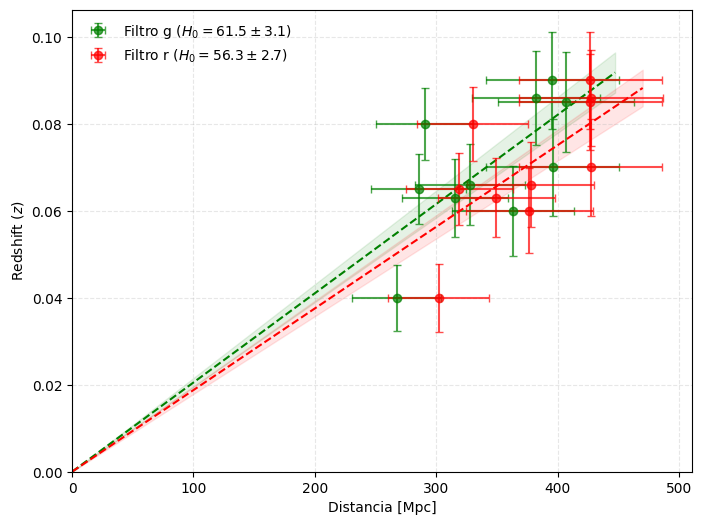

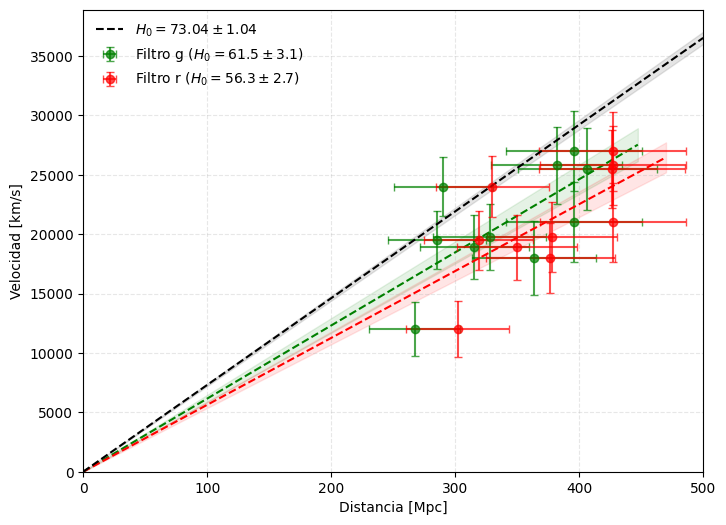

In [ ]:
# Valores teóricos
H0_teo      = 73.04
sigmaHO_teo = 1.04
CSPEED      = const.c.to(u.km / u.s).value


# Función del modelo
def hubble_law(d, H0):
    return (H0 / CSPEED) * d

fig_z, ax_z = plt.subplots(figsize=(8, 6))
fig_v, ax_v = plt.subplots(figsize=(8, 6))

for fid in [1, 2]:
    color = 'green' if fid == 1 else 'red'
    filter_name = "g" if fid == 1 else "r"
    
    dists, zeds, ddists = [], [], []
    
    for oid in metalcs:
        if fid in metalcs[oid]:
            dist      = metalcs[oid][fid]['dist'] / 1e6      # Mpc
            ddist_val = metalcs[oid][fid]['sigmadist'] / 1e6 # Mpc
            redshift  = metalcs[oid][fid]['redshift']
            
            dists.append(dist)
            ddists.append(ddist_val)
            zeds.append(redshift)
    
    # Convertir a numpy arrays
    dists  = np.array(dists)
    zeds   = np.array(zeds)
    ddists = np.array(ddists)

    # Ajuste (Fit) para obtener H0 específico de este filtro
    popt, pcov = curve_fit(hubble_law, dists, zeds)
    H0  = popt[0]
    dH0 = np.sqrt(pcov[0][0])
    
    # Preparar líneas del modelo (base en Redshift)
    d_line = np.linspace(0, np.max(dists) * 1.1, 100)
    y_model = hubble_law(d_line, H0)
    y_upper = hubble_law(d_line, H0 + dH0)
    y_lower = hubble_law(d_line, H0 - dH0)
    
    # Error propagado en redshift
    dzeds = (H0 / CSPEED) * ddists 

    label_fit = f'Filtro {filter_name} ($H_0={H0:.1f} \pm {dH0:.1f}$)'

    # --- GRÁFICO 1: REDSHIFT ---
    ax_z.errorbar(dists, zeds, xerr=ddists, yerr=dzeds, marker='o', ls='', 
                  color=color, label=label_fit, alpha=0.7, capsize=3)
    ax_z.plot(d_line, y_model, color=color, linestyle='--')
    ax_z.fill_between(d_line, y_lower, y_upper, color=color, alpha=0.1)

    # --- GRÁFICO 2: VELOCIDAD ---
    # Convertimos a velocidad multiplicando por CSPEED
    vels  = zeds * CSPEED
    dvels = dzeds * CSPEED
    
    ax_v.errorbar(dists, vels, xerr=ddists, yerr=dvels, marker='o', ls='', 
                  color=color, label=label_fit, alpha=0.7, capsize=3)
    ax_v.plot(d_line, y_model * CSPEED, color=color, linestyle='--')
    ax_v.fill_between(d_line, y_lower * CSPEED, y_upper * CSPEED, color=color, alpha=0.1)
    

# Figura Z (Redshift)
ax_z.set_ylabel('Redshift ($z$)')
ax_z.set_xlabel('Distancia [Mpc]')
ax_z.legend(frameon=False)
ax_z.grid(True, linestyle='--', alpha=0.3)
ax_z.set_xlim(left=0)
ax_z.set_ylim(bottom=0)

# Figura V (Velocidad)
d_line_teo = np.linspace(0, 500, 100)
v_teo_up  = hubble_law(d_line_teo, H0_teo + sigmaHO_teo)*CSPEED
v_teo_low = hubble_law(d_line_teo, H0_teo - sigmaHO_teo)*CSPEED
v_teo_cen = hubble_law(d_line_teo, H0_teo)*CSPEED
ax_v.plot(d_line_teo, v_teo_cen, color='black', linestyle='--', 
        label=rf'$H_{0} = {H0_teo} \pm {sigmaHO_teo}$')
ax_v.fill_between(d_line_teo, v_teo_low, v_teo_up, color='black', alpha=0.1)

ax_v.set_ylabel('Velocidad [km/s]')
ax_v.set_xlabel('Distancia [Mpc]')
ax_v.legend(frameon=False)
ax_v.grid(True, linestyle='--', alpha=0.3)
ax_v.set_xlim(left=0, right=500)
ax_v.set_ylim(bottom=0)
fig_v.savefig('results/hubble_diagram_by_filter.png', dpi=300, bbox_inches='tight')
plt.show()

Los resultados del ajuste para ambos filtros son los siguientes:

| Filtro | $H_0$ (km/s/Mpc) | Incer | Error |
|:------:|:----------------:|:-----:|:-----:|
|   g    | 61.54            | 3.1   | 15%   |
|   r    | 56.31            | 2.7   | 23%   |

Los valores obtenidos no difieren significativamente de los valores aceptados de la constante de Hubble, que se encuentran en el rango de 67 a 74 km/s/Mpc dependiendo del método de medición utilizado.
Esto refuerza la validez del método utilizado para estimar las distancias a las supernovas tipo Ia y su relación con el redshift.


